### 상위 20개 주제별 상위 20개 TF-IDF 단어

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Mecab
import re

In [15]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [27]:
# 주제별로 TF-IDF를 계산하고 상위 20개의 단어를 추출하는 함수

# 데이터 전처리 및 특수 문자 제거 함수
def clean_special_characters_and_whitespace(df):
    df['topic_cleaned'] = df['topic'].str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
    return df

# #과 # 사이에 들어있는 단어 제거 
def remove_hashtag_words(text):
    return re.sub(r'#\S+#', '', text)

# Mecab을 이용해 명사만 추출하는 함수
# dicr 폴더가 있는 경로로 설정!  
def extract_nouns(text):
    mecab = Mecab(dicpath='/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ko-dic')
    return ' '.join(mecab.nouns(text))


def compute_tfidf_per_topic(df, stop_words, top_n=20):
    result = []

    
    # 각 주제별로 그룹화하여 TF-IDF 계산
    for topic, group in df.groupby('topic_cleaned'):
        dialogues = group['dialogue'].dropna().apply(remove_hashtag_words).apply(extract_nouns)
        
        # TF-IDF 벡터화 (불용어 설정 포함)
        tfidf_vectorizer = TfidfVectorizer(max_features=top_n, stop_words=stop_words)
        tfidf_matrix = tfidf_vectorizer.fit_transform(dialogues)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        
        # 각 주제별 상위 20개 단어와 TF-IDF 점수를 저장
        tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores})
        tfidf_df_sorted = tfidf_df.sort_values(by='tfidf_score', ascending=False).head(top_n)
        
        # topic과 함께 저장
        tfidf_df_sorted['topic'] = topic
        result.append(tfidf_df_sorted)
    
    # 모든 주제에 대한 결과를 합침
    final_result = pd.concat(result, ignore_index=True)
    
    return final_result

# 상위 20개 주제를 기준으로 TF-IDF 계산
def top_n_topics_tfidf(df, stop_words, top_n_topics=20, top_n_words=20):
    # 상위 n개의 주제를 추출
    top_topics = df['topic_cleaned'].value_counts().head(top_n_topics).index
    
    # 상위 n개의 주제만 필터링
    filtered_df = df[df['topic_cleaned'].isin(top_topics)]
    
    # 주제별 TF-IDF 계산
    return compute_tfidf_per_topic(filtered_df, stop_words, top_n=top_n_words)

# 불용어 리스트
stopwords = [
    '우리', '당신', '그녀', '그분','저희', '누구',
    '그것', '그거','그건', '이건', '그게', '무엇', '그곳', '여기', '거기', '어디', 
    '이번','나중', '그때', '다음', '잠시', '하루','동안',
    '하나', '정도', '얼마',
    '안녕', '감사', '실례', '미안', '물론', '오랜만','말씀', 
    '주세요', '가지', '건가요','가요','때문',
    '스미스','브라운','화이트', '메리','마이크', '린다'
    '이야기', '얘기', '엄마', '중요', '필요','시작', '생각','시간','사람','자신'
]
# '오른쪽','왼쪽','직진'
# '오후','저녁','오전','아침','점심', '주말'
#'생각', '필요', '시작', '확인', '계획', '준비', '가능', '약속', '방문', '전화', 
# '이야기', '기회', '제품', '정보', '시간', '사람', '회사', '날씨', '친구', '영화', '질문',
    

# 데이터 불러오기 
data = pd.read_csv('/data/ephemeral/home/data/train.csv')

# 데이터 전처리 
cleaned_data = clean_special_characters_and_whitespace(data)

# 상위 20개 주제에 대해 TF-IDF 계산 (불용어 포함)
final_tfidf_df = top_n_topics_tfidf(cleaned_data, stop_words=stopwords)

# 결과 확인
final_tfidf_df.head()


,word,tfidf_score,topic
0,버스,15.160302,길 묻기
1,오른쪽,10.640281,길 묻기
2,왼쪽,10.626626,길 묻기
3,신호등,6.891580,길 묻기
4,우체국,6.436875,길 묻기


In [28]:
final_tfidf_df['topic'].unique()


array(['길 묻기', '길 안내', '날씨', '면접', '비즈니스 대화', '사회적 만남', '쇼핑', '약속 잡기',
       '여행', '영화', '음식 주문', '인터뷰', '일상 대화', '전화 통화', '정보 요청', '주말 계획',
       '직업 면접', '체크인', '초대', '휴가'], dtype=object)

In [29]:
# Grouping the data by 'topic' and combining the words for each topic
def group_words_by_topic(dataframe):
    grouped_df = dataframe.groupby('topic').agg({
        'word': lambda x: ', '.join(x),  # Combine all words for each topic
        'tfidf_score': 'mean'  # Optionally, we can compute the mean TF-IDF score
    }).reset_index()
    
    return grouped_df

# Apply the function to the dataframe
grouped_words_df = group_words_by_topic(final_tfidf_df)

In [41]:
grouped_words_df=grouped_words_df.to_csv("grouped_words_df.csv",index=None)

In [31]:
import pandas as pd

# 주제별 TF-IDF 결과가 저장된 DataFrame에서 쉼표로 구분된 단어들을 개별 단어로 처리하여 빈도별로 정렬하는 함수
def get_word_frequencies(df):
    # 'word' 열의 각 셀에 있는 쉼표로 구분된 단어들을 모두 분리
    all_words = df['word'].str.split(',').explode().str.strip()  # 쉼표로 나누고 공백 제거
    
    # 각 단어의 빈도를 계산
    word_counts = all_words.value_counts().reset_index()
    word_counts.columns = ['word', 'frequency']  # 열 이름을 'word'와 'frequency'로 설정
    
    return word_counts

# 주제별 TF-IDF DataFrame에서 단어 빈도 계산
word_frequencies_df = get_word_frequencies(grouped_words_df)

# 결과 출력 (빈도별로 정렬된 데이터프레임)
print(word_frequencies_df)


       word  frequency
0        전화          7
1        친구          7
2        회사          6
3        아침          6
4        버스          5
5        계획          5
6        주말          5
7        날씨          5
8        대학          5
9        도시          5
10       영화          5
11       식사          4
12       티켓          4
13       오후          4
14       저녁          4
15       음식          4
16       호텔          4
17       건물          4
18      이야기          4
19      오른쪽          3
20      금요일          3
21       뉴욕          3
22       예정          3
23       달러          3
24       확인          3
25       예약          3
26       질문          3
27       해변          3
28       영어          3
29       여행          3
30       휴가          3
31       준비          3
32       사용          3
33       이름          3
34       도착          3
35       학교          3
36     스트리트          3
37       문제          3
38       공부          3
39       제공          3
40       귀사          3
41       경험          3
42       런던

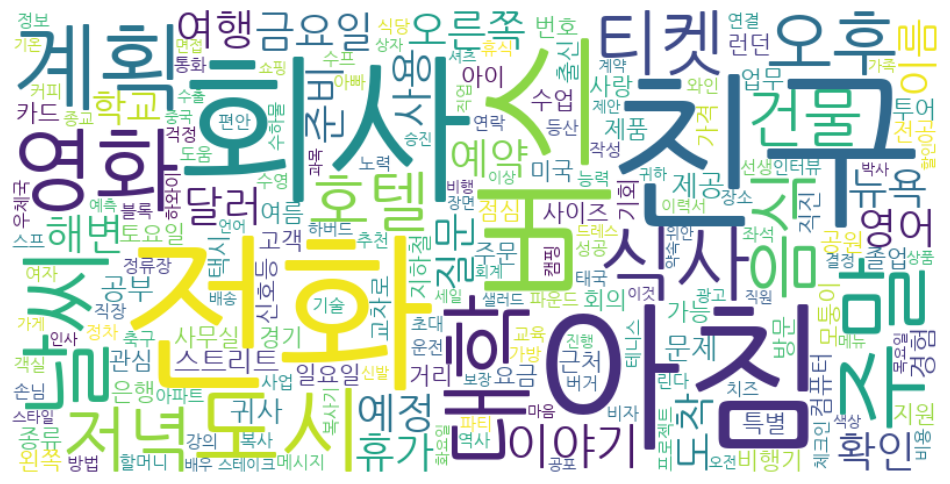

In [40]:
#  WordCloud로 시각화하기 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# WordCloud를 만들기 위해 TF-IDF 결과를 활용
def generate_wordcloud(df):
    # 'word'와 'frequency'를 기반으로 딕셔너리 형태로 변환
    word_freq = dict(zip(df['word'], df['frequency']))
    
    # WordCloud 생성
    wordcloud = WordCloud(
        font_path='/data/ephemeral/home/NANUMGOTHIC.TTF',
        width=800, height=400,
        background_color='white'
    ).generate_from_frequencies(word_freq)
    
    # 시각화
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # 축을 숨김
    plt.show()

# 워드클라우드 생성
generate_wordcloud(word_frequencies_df)


주제 대분류하기 

- 건강: 병원 방문, 건강 상담, 운동 계획, 백신 접종 등
- 일상생활: 쇼핑, 요리, 청소, 가구 구매, 가전제품 구매 등
- 여가 활동: 영화 감상, 댄스, TV 시청, 음악 감상, 여행 계획 등
- 경제: 가격 협상, ATM 사용, 은행 서비스 등
- 사회적 대화: 직장, 친구와 대화, 가족 모임 등
- 교육: 학업, 수업 등록, 시험 준비, 과제 작성 등
- 기타: 그 외의 특별한 주제들